### Handle dependecy imports

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import os
from matplotlib import pyplot as plt
import numpy as np

### Set image dimensions and global variables

In [5]:
IMG_HEIGHT=48 
IMG_WIDTH = 48
batch_size=32

train_data_dir='train/'
validation_data_dir='test/'

### Set up data training

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='grayscale',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Verify generator by plotting random faces with their labels

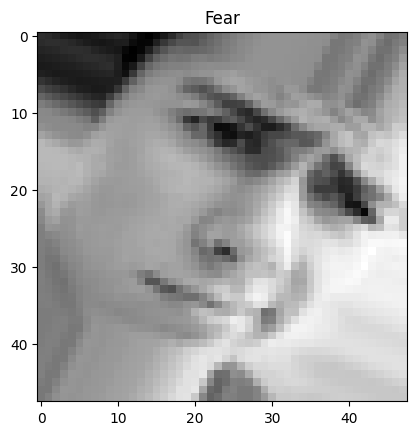

In [11]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

### Create the Model

In [16]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
          activation='relu', input_shape=(48, 48, 1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())


num_train_imgs = 0
for root, dirs, files in os.walk(train_data_dir):
    num_train_imgs += len(files)

num_test_imgs = 0
for root, dirs, files in os.walk(validation_data_dir):
    num_test_imgs += len(files)


epochs = 10

history = model.fit(train_generator,
                    steps_per_epoch=num_train_imgs//batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=num_test_imgs//batch_size)

model.save('emotion_detection_model_100epochs.h5')


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                 

### Test the generated model accuracy

1/1 [==============================] - 0s 96ms/step
Accuracy =  0.59375


<AxesSubplot: >

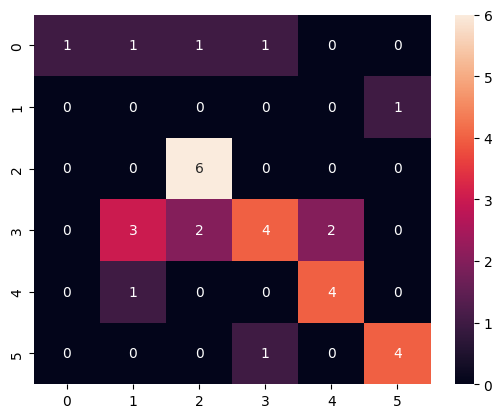

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.models import load_model


# Test the model
my_model = load_model('emotion_detection_model_100epochs.h5', compile=False)

# Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions = my_model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

print("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

# Confusion Matrix - verify accuracy of each class

cm = confusion_matrix(test_labels, predictions)
# print(cm)
sns.heatmap(cm, annot=True)

### Show plots of the predictions

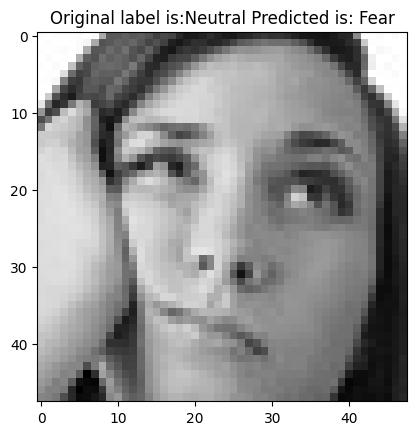

In [30]:
class_labels = ['Angry', 'Disgust', 'Fear',
                'Happy', 'Neutral', 'Sad', 'Surprise']
# Check results on a few select images
n = random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:, :, 0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: " + pred_labl)
plt.show()
